In [1]:
import numpy as np
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from models.CNN import create_cnn_model

In [2]:
def load(f):
    # Move up one directory when loading the data
    file_path = os.path.join('../../../', f)
    return np.load(file_path)['arr_0']

# Load the data
x_train = load('kmnist-train-imgs.npz')/ 255.0
x_test = load('kmnist-test-imgs.npz')/ 255.0
y_train = load('kmnist-train-labels.npz')
y_test = load('kmnist-test-labels.npz')
# Reshape the data for CNN input
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [3]:
input_shape = x_train.shape[1:]  # 784 for KMNIST
num_classes = y_train.max() + 1
x_train_aug, x_val, y_train_aug, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


In [4]:
hyperparameters = {
    'num_layers': 3,
    'filters': [32, 64, 64],
    'kernel_sizes': [(3, 3), (3, 3), (3, 3)],
    'activations': ['relu', 'relu', 'relu'],
    'dense_units': 64,
    'dense_activation': 'relu',
    'pooling': 'avg',
    'batch_normalization': True
}

In [6]:
best_model_rand_noise = create_cnn_model(input_shape, num_classes, hyperparameters)
best_model_no_noise = create_cnn_model(input_shape, num_classes, hyperparameters)
best_model_radial_noise = create_cnn_model(input_shape, num_classes, hyperparameters)
datagen_rand_noise = ImageDataGenerator(
    preprocessing_function=lambda x: np.clip(x + np.random.normal(0, 0.1, x.shape), 0, 1)  # Noise injection
)
datagen_radial_noise = ImageDataGenerator(
    preprocessing_function=lambda x: np.clip(x + np.random.normal(0, 0.1, x.shape) * np.sqrt(np.sum(np.square(np.indices(x.shape[1:3]).T - np.array(x.shape[1:3])/2), axis=2)).reshape(1, x.shape[1], x.shape[2], 1) / np.max(np.sqrt(np.sum(np.square(np.indices(x.shape[1:3]).T - np.array(x.shape[1:3])/2), axis=2))), 0, 1)  # Radial noise injection
    )
datagen_no_noise = ImageDataGenerator()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
datagen_val = ImageDataGenerator()
# Wrap the datagen with our custom generator
train_generator_rand_noise = datagen_rand_noise.flow(x_train_aug, y_train_aug, batch_size=32)
train_generator_radial_noise = datagen_radial_noise.flow(x_train_aug, y_train_aug, batch_size=32)
train_generator_no_noise = datagen_no_noise.flow(x_train_aug, y_train_aug, batch_size=32)
val_generator = datagen_val.flow(x_val, y_val, batch_size=32)
# Train the model with custom augmentation
history_rand_noise = best_model_rand_noise.fit(train_generator_rand_noise,
                        epochs=20,
                        validation_data=val_generator,  
                        verbose=1,
                        callbacks=[early_stopping])
history_radial_noise = best_model_radial_noise.fit(train_generator_radial_noise,
                        epochs=20,
                        validation_data=val_generator,  
                        verbose=1,
                        callbacks=[early_stopping])
history_no_noise = best_model_no_noise.fit(train_generator_no_noise,
                        epochs=20,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=[early_stopping])

# Evaluate on the test set
test_loss_rand_noise, test_accuracy_rand_noise = best_model_rand_noise.evaluate(x_test, y_test, verbose=0)
test_loss_no_noise, test_accuracy_no_noise = best_model_no_noise.evaluate(x_test, y_test, verbose=0)
test_loss_radial_noise, test_accuracy_radial_noise = best_model_radial_noise.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy with Random Noise Injection: {test_accuracy_rand_noise:.4f}")
print(f"Test accuracy with Radial Noise Injection: {test_accuracy_radial_noise:.4f}")
print(f"Test accuracy without Noise Injection: {test_accuracy_no_noise:.4f}")
print(f"Test loss with Random Noise Injection: {test_loss_rand_noise:.4f}")
print(f"Test loss with Radial Noise Injection: {test_loss_radial_noise:.4f}")
print(f"Test loss without Noise Injection: {test_loss_no_noise:.4f}")

Epoch 1/20
1688/1688 [==============================] - 14s 6ms/step - loss: 0.2187 - accuracy: 0.9408 - val_loss: 0.1093 - val_accuracy: 0.9652
Epoch 2/20
1688/1688 [==============================] - 9s 6ms/step - loss: 0.0732 - accuracy: 0.9789 - val_loss: 0.0625 - val_accuracy: 0.9797
Epoch 3/20
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0502 - accuracy: 0.9850 - val_loss: 0.0482 - val_accuracy: 0.9850
Epoch 4/20
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0392 - accuracy: 0.9881 - val_loss: 0.0445 - val_accuracy: 0.9865
Epoch 5/20
1688/1688 [==============================] - 9s 6ms/step - loss: 0.0326 - accuracy: 0.9898 - val_loss: 0.1013 - val_accuracy: 0.9715
Epoch 6/20
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0290 - accuracy: 0.9909 - val_loss: 0.0487 - val_accuracy: 0.9847
Epoch 7/20
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0225 - accuracy: 0.9931 - val_loss: 0.0533 - val_accuracy

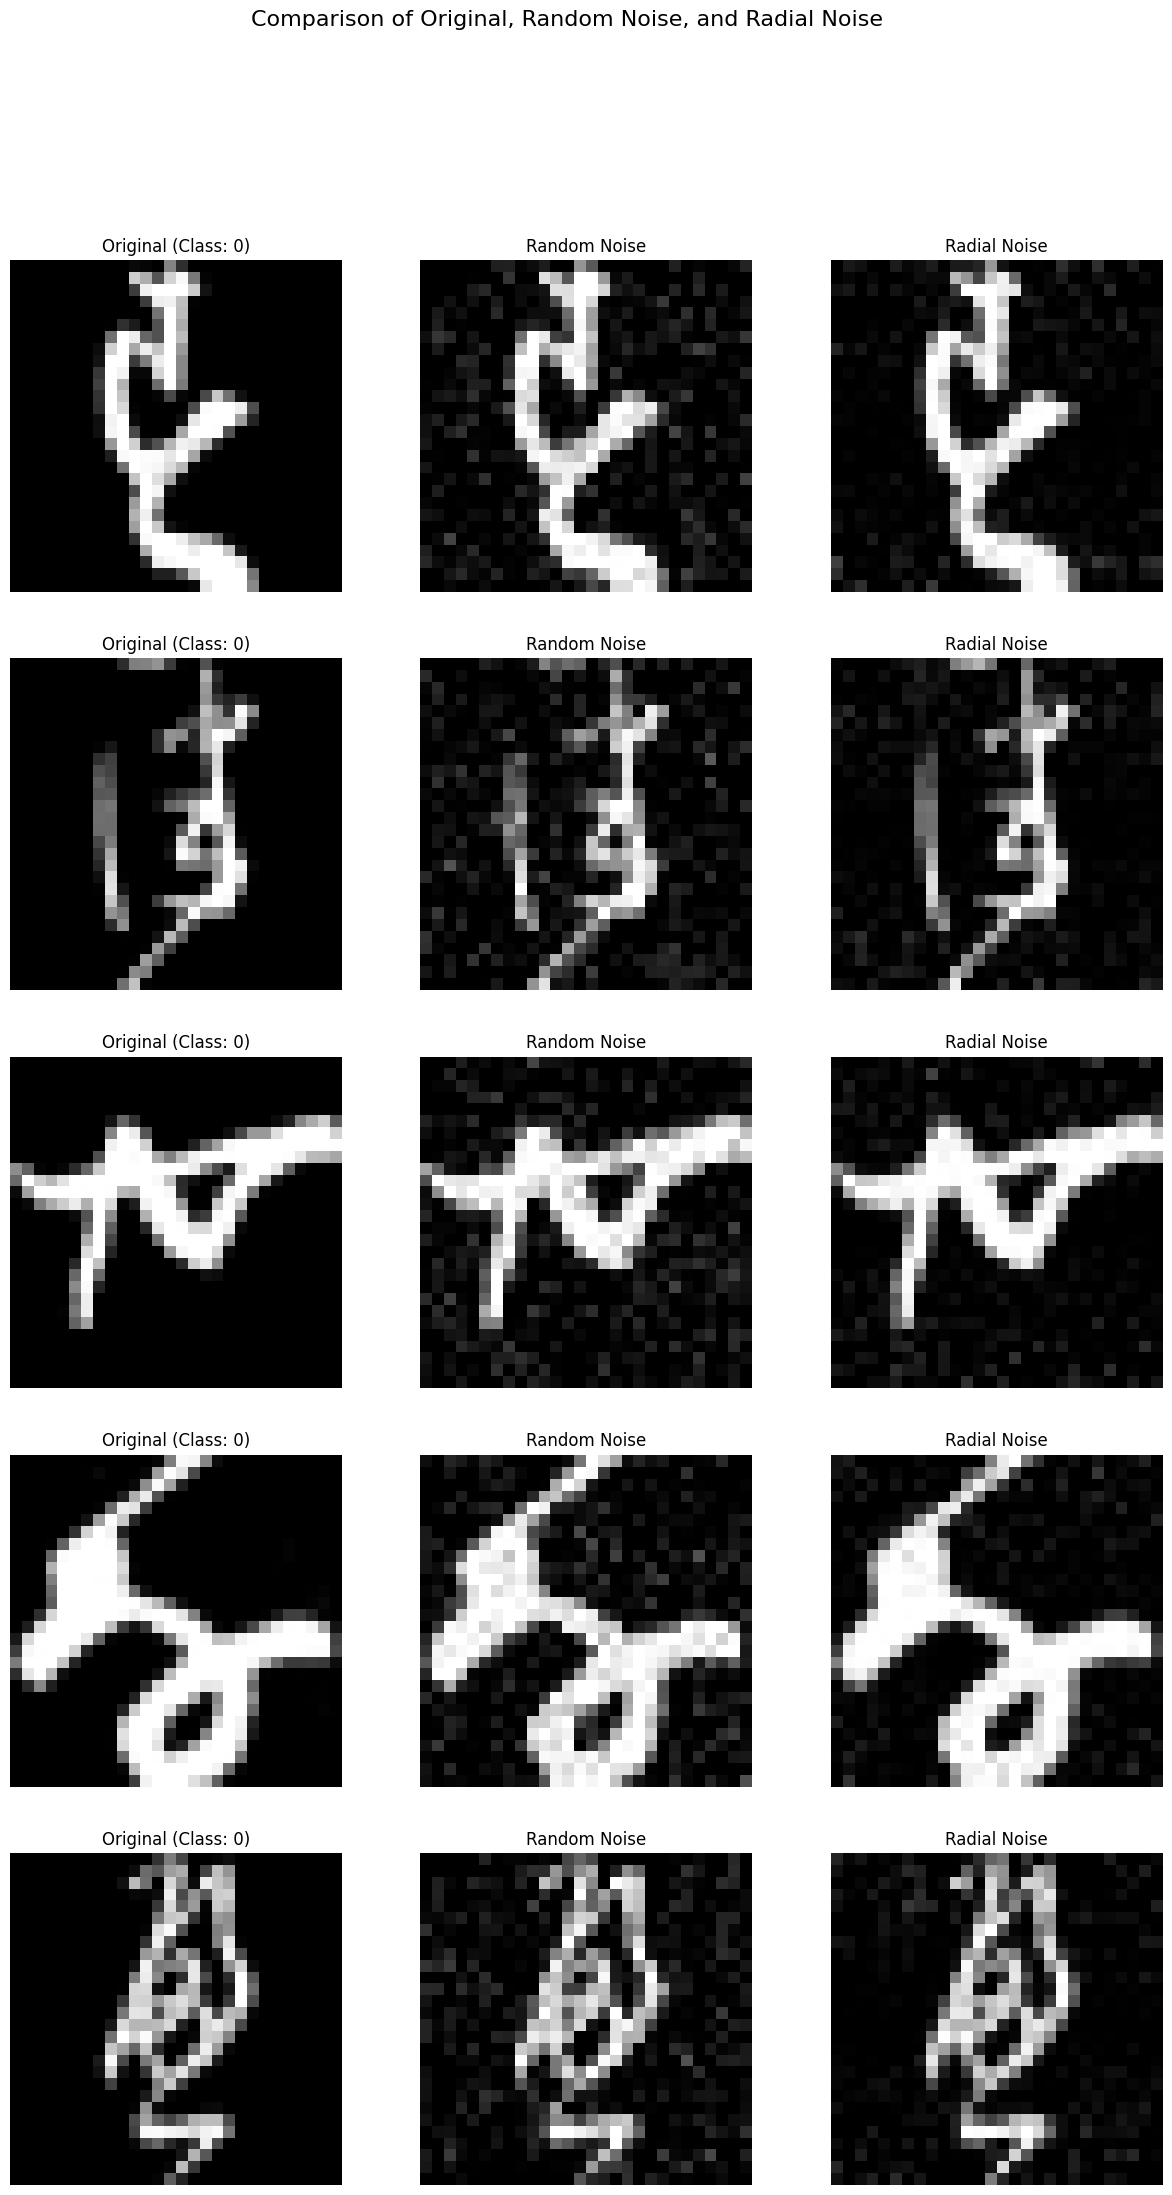

In [13]:
# Function to apply random noise
def apply_random_noise(image):
    return np.clip(image + np.random.normal(0, 0.1, image.shape), 0, 1)

# Function to apply radial noise
def apply_radial_noise(image):
    radial_factor = np.sqrt(np.sum(np.square(np.indices(image.shape[1:3]).T - np.array(image.shape[1:3])/2), axis=2))
    radial_factor = radial_factor.reshape(1, image.shape[1], image.shape[2], 1) / np.max(radial_factor)
    return np.clip(image + np.random.normal(0, 0.1, image.shape) * radial_factor, 0, 1)

# Select a few random samples
num_samples = 5
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)

# Create a figure to display the samples
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
fig.suptitle("Comparison of Original, Random Noise, and Radial Noise", fontsize=16)


for i, idx in enumerate(sample_indices):
    original_image = x_test[idx]
    random_noise_image = apply_random_noise(original_image)
    radial_noise_image = apply_radial_noise(original_image)
    
    axes[i, 0].imshow(original_image.squeeze(), cmap='gray')
    axes[i, 0].set_title(f"Original (Class: {np.argmax(y_test[idx])})")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(random_noise_image.squeeze(), cmap='gray')
    axes[i, 1].set_title("Random Noise")
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(radial_noise_image.squeeze(), cmap='gray')
    axes[i, 2].set_title("Radial Noise")
    axes[i, 2].axis('off')
plt.show()
